
# **Evolving Networks in the Realm of Ice and Fire: A Comparative Network Analysis of "Game of Thrones" Books One and Five**


## Giovanni Dal Mas


### Network Science Project 2023/24

# 1. Introduction

This project embarks on a journey through the intricate web of relationships in George R. R. Martin's epic fantasy series, "Game of Thrones". Utilizing the power of network science, we delve into the complex character interactions, comparing the networks formed in the first book, "A Game of Thrones", with those in the fifth and last book, "A Dance with Dragons".

The analysis employs a range of network analysis techniques to uncover the evolution of the network structure and the shifting importance and roles of characters over the course of the narrative.




#2. Software and Dataset

## 2.0 Libraries and Importing Data

In [46]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sps
import matplotlib.pyplot as plt
import itertools
import networkx as nx
!pip install igraph
import igraph as ig
import ast
import networkx.algorithms.community as nx_comm
import math

!pip install cairocffi
import cairocffi as cairo
import matplotlib.colors as mcolors

from IPython.display import Image
!pip install louvain
import louvain
import time
import pickle
import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/got_dataset')

Let's import book 1 and book 5 datasets with the undirected connections among characters and weights based on the number of interactions in the book. The datsets were taken from kaggle: https://www.kaggle.com/code/mmmarchetti/game-of-thrones-network-analysis/notebook

In [4]:
# Book 1

book1=pd.read_csv("dataset/book1.csv")
book1.head()

,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1


Let's rearrange the dataframe in a form that will allows us to to work better in the next phases, included on Gephi. Both the nodes and edges files modified will be saved as csv files to be uploaded on Gephi. In particular we will change the columns names in order to have the nodes file in the form 'id, label' and the edges file in the form 'Source, Target, Weight', with this specific names (respecting the capital and lower letters).

In [5]:
nodes = pd.DataFrame(book1['Source'].append(book1['Target']).unique(), columns=['name'])
nodes.reset_index(inplace=True)
nodes.rename(columns={'index': 'id', 'name': 'label'}, inplace=True)
nodes.to_csv('got_nodes1.csv', index=False)


<ipython-input-5-78562dc2ec3b>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes = pd.DataFrame(book1['Source'].append(book1['Target']).unique(), columns=['name'])


Import data: Book 1


In [6]:
got_nodes1 = pd.read_csv('got_nodes1.csv')
got_nodes1.head()

,id,label
0,0,Addam-Marbrand
1,1,Aegon-I-Targaryen
2,2,Aemon-Targaryen-(Maester-Aemon)
3,3,Aerys-II-Targaryen
4,4,Aggo


Edges book 1

In [7]:
# Convert 'weight' to float and rename the column to 'Weight'
# (capital letter, for Gephi it's important to have the edges data with title column names: Source, Target, Weight)
book1['weight'] = book1['weight'].astype(float)
book1 = book1.rename(columns={'weight': 'Weight'})

# Select the necessary columns
edges1 = book1[['Source', 'Target', 'Weight']]


In [8]:
edges1.head()

,Source,Target,Weight
0,Addam-Marbrand,Jaime-Lannister,3.0
1,Addam-Marbrand,Tywin-Lannister,6.0
2,Aegon-I-Targaryen,Daenerys-Targaryen,5.0
3,Aegon-I-Targaryen,Eddard-Stark,4.0
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,4.0


In [9]:
# Save the new dataframe to a csv file in order to use it on Gephi later
edges1.to_csv('got_edges1.csv', index=False)

Let's now modify the edges csv file in order to subsitute every label with the character's name with the respective id. This will make easier the import of nodes and edges on Gephi.

In [10]:
# Read the CSV files
got_edges1 = pd.read_csv('got_edges1.csv')
#got_nodes1 = pd.read_csv('got_nodes.csv')

# Check if all 'Source' and 'Target' values exist in 'nodes'
source_values_exist = all(value in got_nodes1['label'].values for value in got_edges1['Source'])
target_values_exist = all(value in got_nodes1['label'].values for value in got_edges1['Target'])

if source_values_exist and target_values_exist:
    # Create dictionaries for mapping names to ids
    source_dict = got_nodes1.set_index('label')['id'].to_dict()
    target_dict = got_nodes1.set_index('label')['id'].to_dict()

    # Replace 'Source' and 'Target' values with their respective 'id'
    got_edges1['Source'] = got_edges1['Source'].map(source_dict)
    got_edges1['Target'] = got_edges1['Target'].map(target_dict)

    # Save the modified DataFrame to a new CSV file
    got_edges1.to_csv('mod_edges1.csv', index=False)
else:
    print("Some 'Source' or 'Target' values do not exist in 'nodes'. Please check your data.")



In [11]:
got_edges1.head()

,Source,Target,Weight
0,0,69,3.0
1,0,137,6.0
2,1,32,5.0
3,1,42,4.0
4,2,6,4.0


Now we repeat all these procedures for the import and preparation of the nodes and edges from book 5.

Import data: Book 5

In [12]:
# Book 5

book5=pd.read_csv("dataset/book5.csv")
book5.head()

,Source,Target,Type,weight,book
0,Aegon-I-Targaryen,Daenerys-Targaryen,undirected,4,5
1,Aegon-Targaryen-(son-of-Rhaegar),Daenerys-Targaryen,undirected,11,5
2,Aegon-Targaryen-(son-of-Rhaegar),Elia-Martell,undirected,4,5
3,Aegon-Targaryen-(son-of-Rhaegar),Franklyn-Flowers,undirected,3,5
4,Aegon-Targaryen-(son-of-Rhaegar),Haldon,undirected,14,5


In [13]:
nodes5 = pd.DataFrame(book5['Source'].append(book5['Target']).unique(), columns=['name'])
nodes5.reset_index(inplace=True)
nodes5.rename(columns={'index': 'id', 'name': 'label'}, inplace=True)
nodes5.to_csv('got_nodes5.csv', index=False)


<ipython-input-13-7a42aa591134>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes5 = pd.DataFrame(book5['Source'].append(book5['Target']).unique(), columns=['name'])


In [14]:
got_nodes5 = pd.read_csv('got_nodes5.csv')
got_nodes5.head()

,id,label
0,0,Aegon-I-Targaryen
1,1,Aegon-Targaryen-(son-of-Rhaegar)
2,2,Aemon-Targaryen-(Maester-Aemon)
3,3,Aenys-Frey
4,4,Aeron-Greyjoy


In [15]:
# Convert 'weight' to float and rename the column to 'Weight'
# (capital letter, for Gephi it's important to have the edges data with title column names: Source, Target, Weight)
book5['weight'] = book5['weight'].astype(float)
book5 = book5.rename(columns={'weight': 'Weight'})

# Select the necessary columns
edges5 = book5[['Source', 'Target', 'Weight']]

In [16]:
edges5.head()

,Source,Target,Weight
0,Aegon-I-Targaryen,Daenerys-Targaryen,4.0
1,Aegon-Targaryen-(son-of-Rhaegar),Daenerys-Targaryen,11.0
2,Aegon-Targaryen-(son-of-Rhaegar),Elia-Martell,4.0
3,Aegon-Targaryen-(son-of-Rhaegar),Franklyn-Flowers,3.0
4,Aegon-Targaryen-(son-of-Rhaegar),Haldon,14.0


In [17]:
# Save the new dataframe to a csv file in order to use it on Gephi later
edges5.to_csv('got_edges5.csv', index=False)

In [18]:
# Read the CSV files
got_edges5 = pd.read_csv('got_edges5.csv')

# Check if all 'Source' and 'Target' values exist in 'nodes'
source_values_exist = all(value in got_nodes5['label'].values for value in got_edges5['Source'])
target_values_exist = all(value in got_nodes5['label'].values for value in got_edges5['Target'])

if source_values_exist and target_values_exist:
    # Create dictionaries for mapping names to ids
    source_dict = got_nodes5.set_index('label')['id'].to_dict()
    target_dict = got_nodes5.set_index('label')['id'].to_dict()

    # Replace 'Source' and 'Target' values with their respective 'id'
    got_edges5['Source'] = got_edges5['Source'].map(source_dict)
    got_edges5['Target'] = got_edges5['Target'].map(target_dict)

    # Save the modified DataFrame to a new CSV file
    got_edges5.to_csv('mod_edges5.csv', index=False)
else:
    print("Some 'Source' or 'Target' values do not exist in 'nodes'. Please check your data.")

In [19]:
got_edges5.head()

,Source,Target,Weight
0,0,61,4.0
1,1,61,11.0
2,1,77,4.0
3,1,81,3.0
4,1,103,14.0


Building Network Book 1

In [20]:
# Read the CSV files
edges_1 = pd.read_csv('mod_edges1.csv', sep=",")
nodes_1 = pd.read_csv('got_nodes1.csv')
got_nw_prop = nx.from_pandas_edgelist(edges_1, 'Source', 'Target', ['Weight'])

# Check if 'id' and 'label' columns exist in 'nodes1'
if 'id' in nodes_1.columns and 'label' in nodes_1.columns:
    nodes_dict = nodes_1.set_index('id')['label'].to_dict()
    nx.set_node_attributes(got_nw_prop, nodes_dict, 'label')
else:
    print("'id' or 'label' column does not exist in 'got_nodes1.csv'.")

print(got_nw_prop.nodes(data=True))
print(got_nw_prop.edges(data=True))


[(0, {'label': 'Addam-Marbrand'}), (69, {'label': 'Jaime-Lannister'}), (137, {'label': 'Tywin-Lannister'}), (1, {'label': 'Aegon-I-Targaryen'}), (32, {'label': 'Daenerys-Targaryen'}), (42, {'label': 'Eddard-Stark'}), (2, {'label': 'Aemon-Targaryen-(Maester-Aemon)'}), (6, {'label': 'Alliser-Thorne'}), (17, {'label': 'Bowen-Marsh'}), (26, {'label': 'Chett'}), (139, {'label': 'Clydas'}), (72, {'label': 'Jeor-Mormont'}), (79, {'label': 'Jon-Snow'}), (140, {'label': 'Samwell-Tarly'}), (3, {'label': 'Aerys-II-Targaryen'}), (19, {'label': 'Brandon-Stark'}), (48, {'label': 'Gerold-Hightower'}), (78, {'label': 'Jon-Arryn'}), (124, {'label': 'Robert-Baratheon'}), (4, {'label': 'Aggo'}), (40, {'label': 'Drogo'}), (75, {'label': 'Jhogo'}), (82, {'label': 'Jorah-Mormont'}), (114, {'label': 'Quaro'}), (141, {'label': 'Rakharo'}), (5, {'label': 'Albett'}), (53, {'label': 'Halder'}), (116, {'label': 'Rast'}), (50, {'label': 'Grenn'}), (112, {'label': 'Pypar'}), (136, {'label': 'Tyrion-Lannister'}), (7

In [21]:
# Read the CSV files
edges_1 = pd.read_csv('mod_edges1.csv', sep=",")
nodes_1 = pd.read_csv('got_nodes1.csv')

# Create a NetworkX graph from the edges DataFrame
got_nw_prop = nx.from_pandas_edgelist(edges_1, 'Source', 'Target', ['Weight'])

# Create a dictionary from the nodes DataFrame
nodes_dict = nodes_1.set_index('id').to_dict('index')

# Add nodes to the graph
got_nw_prop.add_nodes_from(nodes_dict.items())

# Print node and edge attributes
print(got_nw_prop.nodes(data=True))
print(got_nw_prop.edges(data=True))

# Convert the NetworkX graph to an igraph graph
g_prop1 = ig.Graph.from_networkx(got_nw_prop)

# Print node and edge attributes
for vertice in g_prop1.vs:
    print(vertice.attributes())
for edge in g_prop1.es:
    print(edge.attributes())


[(0, {'label': 'Addam-Marbrand'}), (69, {'label': 'Jaime-Lannister'}), (137, {'label': 'Tywin-Lannister'}), (1, {'label': 'Aegon-I-Targaryen'}), (32, {'label': 'Daenerys-Targaryen'}), (42, {'label': 'Eddard-Stark'}), (2, {'label': 'Aemon-Targaryen-(Maester-Aemon)'}), (6, {'label': 'Alliser-Thorne'}), (17, {'label': 'Bowen-Marsh'}), (26, {'label': 'Chett'}), (139, {'label': 'Clydas'}), (72, {'label': 'Jeor-Mormont'}), (79, {'label': 'Jon-Snow'}), (140, {'label': 'Samwell-Tarly'}), (3, {'label': 'Aerys-II-Targaryen'}), (19, {'label': 'Brandon-Stark'}), (48, {'label': 'Gerold-Hightower'}), (78, {'label': 'Jon-Arryn'}), (124, {'label': 'Robert-Baratheon'}), (4, {'label': 'Aggo'}), (40, {'label': 'Drogo'}), (75, {'label': 'Jhogo'}), (82, {'label': 'Jorah-Mormont'}), (114, {'label': 'Quaro'}), (141, {'label': 'Rakharo'}), (5, {'label': 'Albett'}), (53, {'label': 'Halder'}), (116, {'label': 'Rast'}), (50, {'label': 'Grenn'}), (112, {'label': 'Pypar'}), (136, {'label': 'Tyrion-Lannister'}), (7

The visualization and network properties will be provided through Gephi.

Building Network Book 5

In [22]:
# Read the CSV files
edges_5 = pd.read_csv('mod_edges5.csv', sep=",")
nodes_5 = pd.read_csv('got_nodes5.csv')
got_nw_prop5 = nx.from_pandas_edgelist(edges_5, 'Source', 'Target', ['Weight'])

# Check if 'id' and 'label' columns exist in 'nodes1'
if 'id' in nodes_5.columns and 'label' in nodes_5.columns:
    nodes_dict5 = nodes_5.set_index('id')['label'].to_dict()
    nx.set_node_attributes(got_nw_prop5, nodes_dict5, 'label')
else:
    print("'id' or 'label' column does not exist in 'got_nodes1.csv'.")

print(got_nw_prop5.nodes(data=True))
print(got_nw_prop5.edges(data=True))


[(0, {'label': 'Aegon-I-Targaryen'}), (61, {'label': 'Daenerys-Targaryen'}), (1, {'label': 'Aegon-Targaryen-(son-of-Rhaegar)'}), (77, {'label': 'Elia-Martell'}), (81, {'label': 'Franklyn-Flowers'}), (103, {'label': 'Haldon'}), (106, {'label': 'Harry-Strickland'}), (132, {'label': 'Jon-Connington'}), (145, {'label': 'Lemore'}), (191, {'label': 'Rhaegar-Targaryen'}), (231, {'label': 'Rhaenys-Targaryen-(daughter-of-Rhaegar)'}), (200, {'label': 'Rolly-Duckfield'}), (226, {'label': 'Tyrion-Lannister'}), (227, {'label': 'Tywin-Lannister'}), (232, {'label': 'Viserys-Targaryen'}), (230, {'label': 'Yandry'}), (233, {'label': 'Ysilla'}), (2, {'label': 'Aemon-Targaryen-(Maester-Aemon)'}), (55, {'label': 'Clydas'}), (90, {'label': 'Gilly'}), (133, {'label': 'Jon-Snow'}), (205, {'label': 'Samwell-Tarly'}), (217, {'label': 'Stannis-Baratheon'}), (3, {'label': 'Aenys-Frey'}), (116, {'label': 'Hosteen-Frey'}), (221, {'label': 'Theon-Greyjoy'}), (234, {'label': 'Wyman-Manderly'}), (4, {'label': 'Aeron-

In [23]:
# Read the CSV files
#edges_5 = pd.read_csv('mod_edges5.csv', sep=",")
#nodes_5 = pd.read_csv('got_nodes5.csv')

# Create a NetworkX graph from the edges DataFrame
#got_nw_prop = nx.from_pandas_edgelist(edges_5, 'Source', 'Target', ['Weight'])

# Create a dictionary from the nodes DataFrame
nodes_dict5 = nodes_5.set_index('id').to_dict('index')

# Add nodes to the graph
got_nw_prop5.add_nodes_from(nodes_dict5.items())

# Print node and edge attributes
print(got_nw_prop5.nodes(data=True))
print(got_nw_prop5.edges(data=True))

# Convert the NetworkX graph to an igraph graph
g_prop5 = ig.Graph.from_networkx(got_nw_prop5)

# Print node and edge attributes
for vertice in g_prop5.vs:
    print(vertice.attributes())
for edge in g_prop5.es:
    print(edge.attributes())


[(0, {'label': 'Aegon-I-Targaryen'}), (61, {'label': 'Daenerys-Targaryen'}), (1, {'label': 'Aegon-Targaryen-(son-of-Rhaegar)'}), (77, {'label': 'Elia-Martell'}), (81, {'label': 'Franklyn-Flowers'}), (103, {'label': 'Haldon'}), (106, {'label': 'Harry-Strickland'}), (132, {'label': 'Jon-Connington'}), (145, {'label': 'Lemore'}), (191, {'label': 'Rhaegar-Targaryen'}), (231, {'label': 'Rhaenys-Targaryen-(daughter-of-Rhaegar)'}), (200, {'label': 'Rolly-Duckfield'}), (226, {'label': 'Tyrion-Lannister'}), (227, {'label': 'Tywin-Lannister'}), (232, {'label': 'Viserys-Targaryen'}), (230, {'label': 'Yandry'}), (233, {'label': 'Ysilla'}), (2, {'label': 'Aemon-Targaryen-(Maester-Aemon)'}), (55, {'label': 'Clydas'}), (90, {'label': 'Gilly'}), (133, {'label': 'Jon-Snow'}), (205, {'label': 'Samwell-Tarly'}), (217, {'label': 'Stannis-Baratheon'}), (3, {'label': 'Aenys-Frey'}), (116, {'label': 'Hosteen-Frey'}), (221, {'label': 'Theon-Greyjoy'}), (234, {'label': 'Wyman-Manderly'}), (4, {'label': 'Aeron-

## 3 Network Structure

##3.1 Network Properties

Computed through Gephi.


Network Book 1:

- Number of nodes: 187
- Number of edges: 684
- Graph diameter: 7
- Av.Path Length: 2.912
- Graph density: 0.039

Network Book 5:

- Number of nodes: 317
- Number of edges: 760
- Graph diameter: 8
- Av.Path Length: 3.786
- Graph density: 0.015

##3.2 Centrality Measures

Performed on Gephi (tables in the slides).


###3.2.1 Degree Distribution

Book 1

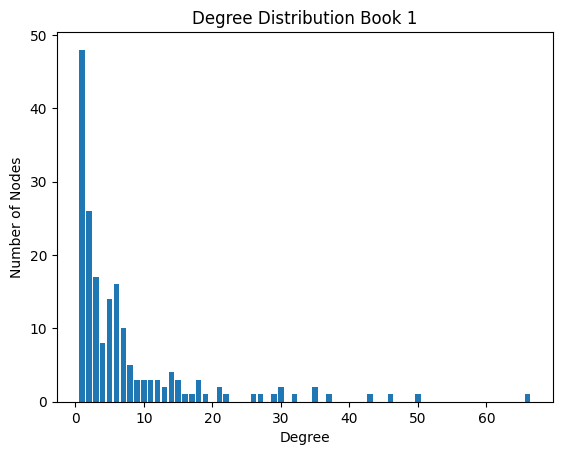

<Figure size 640x480 with 0 Axes>

In [24]:
# Calculate the degrees of each node
degrees1 = [degree for node, degree in got_nw_prop.degree()]

# Get unique degrees and their counts
unique_degrees1, counts = np.unique(degrees1, return_counts=True)

# Plot the degree distribution
plt.bar(unique_degrees1, counts)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution Book 1')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('g1_degree_hist.png', dpi=100)


Book 5

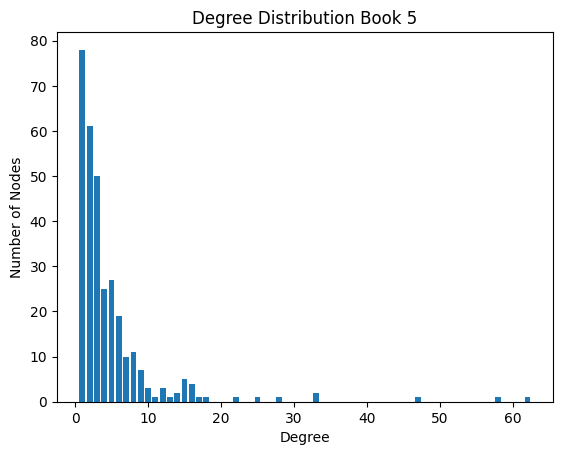

<Figure size 640x480 with 0 Axes>

In [25]:
# Calculate the degrees of each node
degrees5 = [degree for node, degree in got_nw_prop5.degree()]

# Get unique degrees and their counts
unique_degrees5, counts = np.unique(degrees5, return_counts=True)

# Plot the degree distribution
plt.bar(unique_degrees5, counts)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution Book 5')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('g5_degree_hist.png', dpi=100)

To check if the network follows a power law (indicative of a scale-free network).

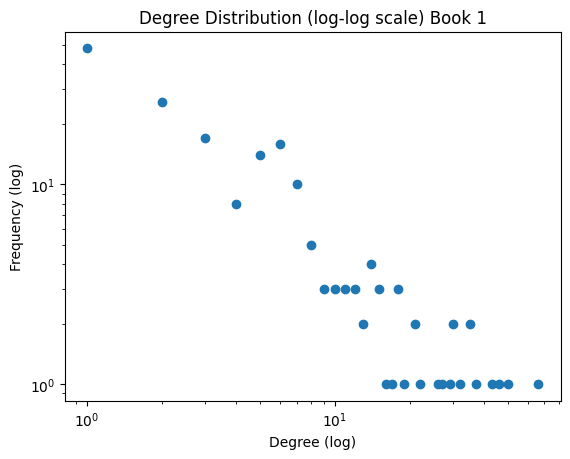

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot the degree distribution (log-log scale)
degree_counts1 = nx.degree_histogram(got_nw_prop)
plt.loglog(range(len(degree_counts1)), degree_counts1, 'o')
plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title('Degree Distribution (log-log scale) Book 1')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('g1_degree_dist.png', dpi=100)


Book 5

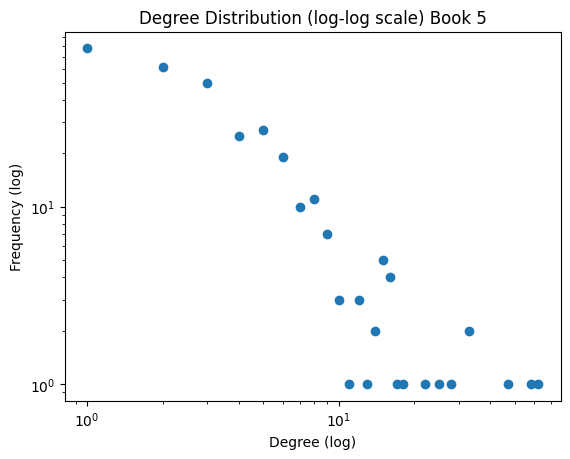

<Figure size 640x480 with 0 Axes>

In [27]:
# Plot the degree distribution (log-log scale) book 5
degree_counts5 = nx.degree_histogram(got_nw_prop5)
plt.loglog(range(len(degree_counts5)), degree_counts5, 'o')
plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title('Degree Distribution (log-log scale) Book 5')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('g5_degree_dist.png', dpi=100)

###3.3 Assortativity

Assortativity  ranges from -1 (perfect disassortativity) to 1 (perfect assortativity).

In [28]:
# Calculate assortativity network book 1
r1 = nx.degree_assortativity_coefficient(got_nw_prop)
print(f"Assortativity Coefficient: {r1}")


Assortativity Coefficient: -0.1636399753256242


In [29]:
# Calculate assortativity network book 1
r5 = nx.degree_assortativity_coefficient(got_nw_prop5)
print(f"Assortativity Coefficient: {r5}")

Assortativity Coefficient: -0.2107674972459491


Both networks show disassortativity with -0.163 and -0.211 respectively.
 Disassortative network tend to have few links
 between nodes of similar degree, with hubs more likely to link with
 nodes with lower degree.

##3.4 Robustness

The robustness of a network can be tested by removing nodes from the network and observing how this affects the size of the largest connected component in the network. This can be done either randomly or by targeting the nodes with the highest degree.


Network Book 1

<ipython-input-30-bb2b1079eba0>:28: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  random_sizes.append(random_graph.clusters().giant().vcount())
<ipython-input-30-bb2b1079eba0>:29: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  targeted_sizes.append(targeted_graph.clusters().giant().vcount())


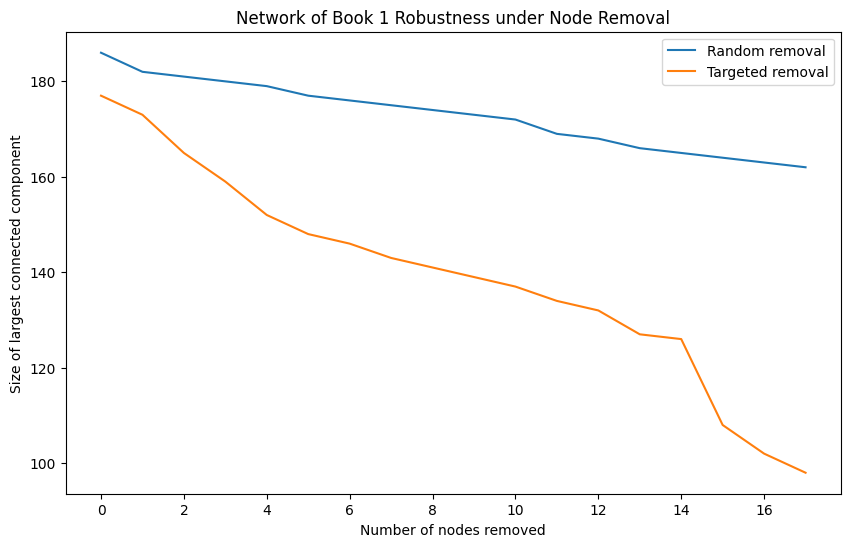

<Figure size 640x480 with 0 Axes>

In [30]:
# Function to perform random node removal
def random_removal(graph, num_nodes_to_remove):
    for _ in range(num_nodes_to_remove):
        node_to_remove = random.choice(list(graph.vs))
        graph.delete_vertices(node_to_remove.index)
    return graph

# Function to perform targeted node removal
def targeted_removal(graph, num_nodes_to_remove):
    for _ in range(num_nodes_to_remove):
        degrees = graph.degree()
        # Node with maximum degree
        node_to_remove = np.argmax(degrees)
        graph.delete_vertices(node_to_remove)
    return graph

# Number of nodes to remove
num_nodes_to_remove = int(0.1 * len(g_prop1.vs))  # 10% of nodes

# Perform node removals and calculate the size of the largest connected component
random_graph = g_prop1.copy()
targeted_graph = g_prop1.copy()
random_sizes = []
targeted_sizes = []
for i in range(num_nodes_to_remove):
    random_graph = random_removal(random_graph, 1)
    targeted_graph = targeted_removal(targeted_graph, 1)
    random_sizes.append(random_graph.clusters().giant().vcount())
    targeted_sizes.append(targeted_graph.clusters().giant().vcount())

# Plot the size of the largest connected component as a function of the number of nodes removed
plt.figure(figsize=(10, 6))
plt.plot(range(num_nodes_to_remove), random_sizes, label='Random removal')
plt.plot(range(num_nodes_to_remove), targeted_sizes, label='Targeted removal')

# Set xticks to be rounded numbers
xticks = np.arange(0, num_nodes_to_remove, step=round(num_nodes_to_remove/10))
plt.xticks(xticks)

plt.xlabel('Number of nodes removed')
plt.ylabel('Size of largest connected component')
plt.title('Network of Book 1 Robustness under Node Removal')
plt.legend()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('robustness_1.png', dpi=100)

<ipython-input-31-f7d620737322>:28: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  random_sizes.append(random_graph.clusters().giant().vcount())
<ipython-input-31-f7d620737322>:29: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  targeted_sizes.append(targeted_graph.clusters().giant().vcount())


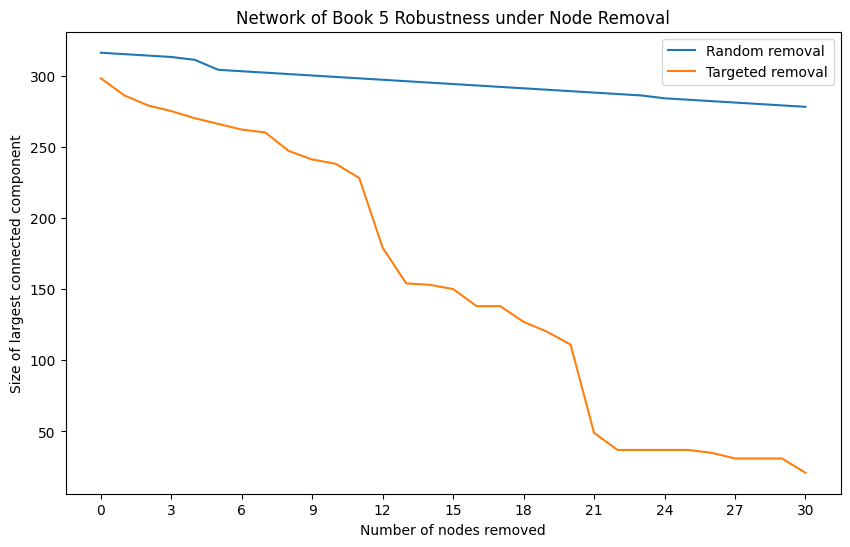

<Figure size 640x480 with 0 Axes>

In [31]:
# Function to perform random node removal
def random_removal(graph, num_nodes_to_remove):
    for _ in range(num_nodes_to_remove):
        node_to_remove = random.choice(list(graph.vs))
        graph.delete_vertices(node_to_remove.index)
    return graph

# Function to perform targeted node removal
def targeted_removal(graph, num_nodes_to_remove):
    for _ in range(num_nodes_to_remove):
        degrees = graph.degree()
        # Node with maximum degree
        node_to_remove = np.argmax(degrees)
        graph.delete_vertices(node_to_remove)
    return graph

# Number of nodes to remove
num_nodes_to_remove = int(0.1 * len(g_prop5.vs))  # 10% of nodes

# Perform node removals and calculate the size of the largest connected component
random_graph = g_prop5.copy()
targeted_graph = g_prop5.copy()
random_sizes = []
targeted_sizes = []
for i in range(num_nodes_to_remove):
    random_graph = random_removal(random_graph, 1)
    targeted_graph = targeted_removal(targeted_graph, 1)
    random_sizes.append(random_graph.clusters().giant().vcount())
    targeted_sizes.append(targeted_graph.clusters().giant().vcount())

# Plot the size of the largest connected component as a function of the number of nodes removed
plt.figure(figsize=(10, 6))
plt.plot(range(num_nodes_to_remove), random_sizes, label='Random removal')
plt.plot(range(num_nodes_to_remove), targeted_sizes, label='Targeted removal')

# Set xticks to be rounded numbers
xticks = np.arange(0, num_nodes_to_remove, step=round(num_nodes_to_remove/10))
plt.xticks(xticks)

plt.xlabel('Number of nodes removed')
plt.ylabel('Size of largest connected component')
plt.title('Network of Book 5 Robustness under Node Removal')
plt.legend()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('robustness_5.png', dpi=100)

Both networks are extremly robust to random node removal, with network of book 5 being the one where the largest connected component is less impacted. On the other hand network 5 is the less robust when it comes to Targeted Attacks where highest degree nodes are removed. It looses 50% percents of its size within 12 nodes removed, while the first network maintains a more gradual decrease with a sudden drop after 14 nodes removed. This reflects the higher density of network 1 and the crucial role of the nodes with highest degree in the network describing characters connections in book 5.

# 4. Community Detection



In [32]:
# table to check to which character the id belongs in the graphs that will be plotted

nodes_1.head(200)

,id,label
0,0,Addam-Marbrand
1,1,Aegon-I-Targaryen
2,2,Aemon-Targaryen-(Maester-Aemon)
3,3,Aerys-II-Targaryen
4,4,Aggo
...,...,...
182,182,Todder
183,183,Matthar
184,184,Othor
185,185,Paxter-Redwyne


In [33]:
nodes_5.head(320)

,id,label
0,0,Aegon-I-Targaryen
1,1,Aegon-Targaryen-(son-of-Rhaegar)
2,2,Aemon-Targaryen-(Maester-Aemon)
3,3,Aenys-Frey
4,4,Aeron-Greyjoy
...,...,...
312,312,William-Foxglove
313,313,Wex-Pyke
314,314,Willow-Witch-eye
315,315,Wylis-Manderly


## 4.1 Girvan Newman

Network Book 1

Number of communities detected: 2
Modularity: 0.16881155740227755


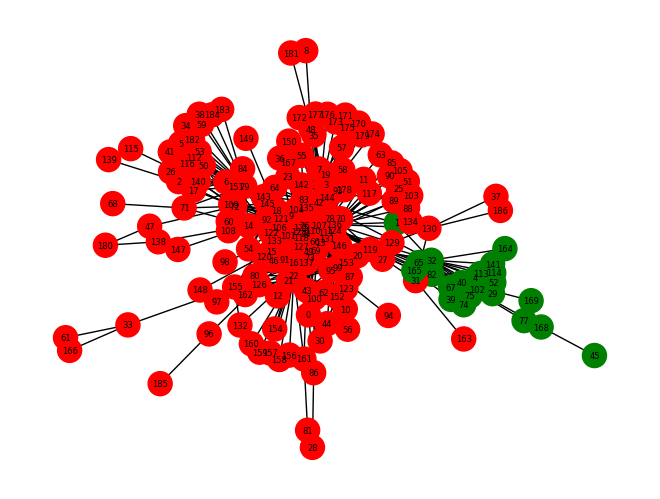

<Figure size 640x480 with 0 Axes>

In [34]:
# Compute communities using Girvan-Newman algorithm
communities_generator = nx_comm.girvan_newman(got_nw_prop)

# Get the first partition of the community (top level split)
top_level_communities = next(communities_generator)
communities_gn1 = [list(c) for c in top_level_communities]

# Print the number of communities detected
print("Number of communities detected:", len(communities_gn1))

# Calculate and print the modularity
modularity_gn1 = nx_comm.modularity(got_nw_prop, communities_gn1)
print("Modularity:", modularity_gn1)

# Create a color map for the communities
colors = ['r', 'g', 'b', 'c', 'm', 'y', '#FFA500', '#800080', '#808000', '#00FFFF', '#008080', '#000080']
color_map = []

# Assign colors to nodes based on their community
for node in got_nw_prop:
    # Find the community of the node
    for i, community in enumerate(communities_gn1):
        if node in community:
            color_map.append(colors[i % len(colors)])
            break

# Draw the graph
nx.draw(got_nw_prop, node_color=color_map, with_labels=True, font_size=6)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('gn_1.png', dpi=100)


From the Girvan Newman algorith two communities emerge. One big cluster merging the main families (Stark, Lannister, Baratheon, etc.) that interact very closely in the first book, as the narrative indulges on the life at court.
The second community represents the clan of Dothraki, the events of which develop far from King's Landing and Stark's Castle, and see the rise of Daenerys as their queen: the Khaleesi. The separation though very semplisistic, is reasonable and coherent with the plot.
Low modulariry at 0.169.

Network Book 5

Number of communities detected: 2
Modularity: 0.4838642659279779


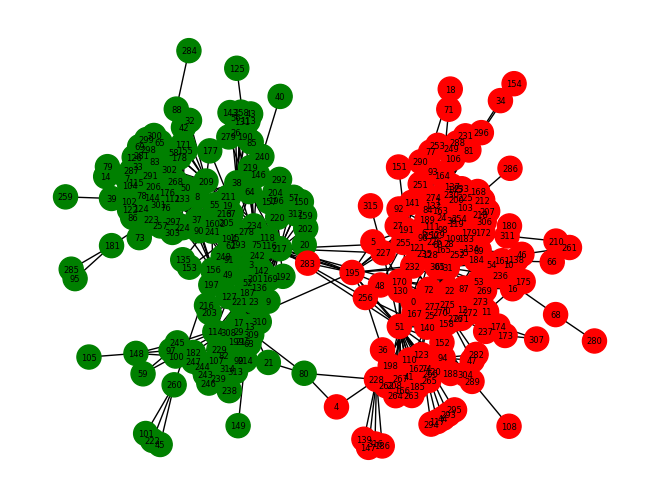

<Figure size 640x480 with 0 Axes>

In [35]:
# Compute communities using Girvan-Newman algorithm
communities_generator = nx_comm.girvan_newman(got_nw_prop5)

# Get the first partition of the community (top level split)
top_level_communities = next(communities_generator)
communities_gn5 = [list(c) for c in top_level_communities]

# Print the number of communities detected
print("Number of communities detected:", len(communities_gn5))

# Calculate and print the modularity
modularity_gn5 = nx_comm.modularity(got_nw_prop5, communities_gn5)
print("Modularity:", modularity_gn5)

# Create a color map for the communities
colors = ['r', 'g', 'b', 'c', 'm', 'y', '#FFA500', '#800080', '#808000', '#00FFFF', '#008080', '#000080']
color_map = []

# Assign colors to nodes based on their community
for node in got_nw_prop5:
    # Find the community of the node
    for i, community in enumerate(communities_gn5):
        if node in community:
            color_map.append(colors[i % len(colors)])
            break

# Draw the graph
nx.draw(got_nw_prop5, node_color=color_map, with_labels=True, font_size=6)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('gn_5.png', dpi=100)


Another time 2 communities are detected.
The modularity score is higher at 0.484, but the division is not very representative of the plot in the 5th book, indeed very intricated.

## 4.2 Label Propagation

Network Book 1

Number of communities detected: 9
Modularity: 0.31149114257378346


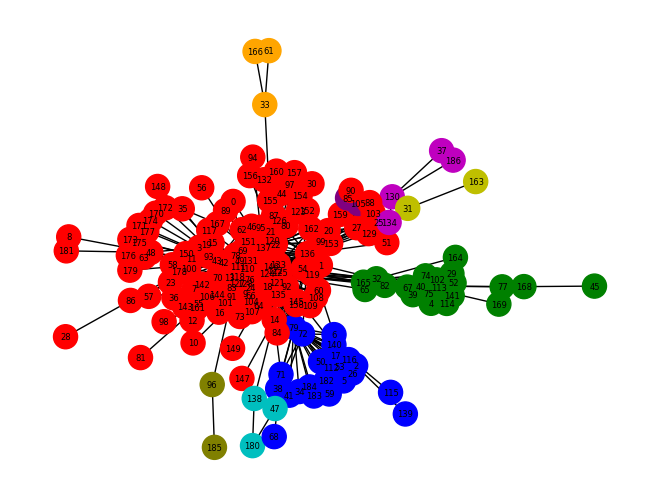

<Figure size 640x480 with 0 Axes>

In [36]:
# Compute communities using label propagation algorithm
communities_lp1 = list(nx_comm.label_propagation_communities(got_nw_prop))

# Print the number of communities detected
print("Number of communities detected:", len(communities_lp1))

# Calculate and print the modularity
modularity_lp1 = nx_comm.modularity(got_nw_prop, communities_lp1)
print("Modularity:", modularity_lp1)


# Create a color map for the communities
colors = ['r', 'g', 'b', 'c', 'm', 'y',  '#FFA500', '#800080', '#808000', '#00FFFF', '#008080', '#000080']
color_map = []

# Assign colors to nodes based on their community
for node in got_nw_prop:
    # Find the community of the node
    for i, community in enumerate(communities_lp1):
        if node in community:
            color_map.append(colors[i % len(colors)])
            break

# Create a layout for the nodes
pos = nx.spring_layout(got_nw_prop)

# Draw the graph
nx.draw(got_nw_prop, pos, node_color=color_map, with_labels=True, font_size=6)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('lp_1.png', dpi=100)



Label Propagation discovers 9 communities. The cluster representing the families of Stark, Lannister and Baratheon is still present (red), as it is the one belonging to Daenerys and the Dothraki (green). It's interesting to see how it emerges a cluster that shows the development of Jon Snow, as he carry out his apprenticeship with Master Aemon beyond the Wall (blue).
Modularity: 0.311.

Network Book 5

Number of communities detected: 33
Modularity: 0.6409470221606648


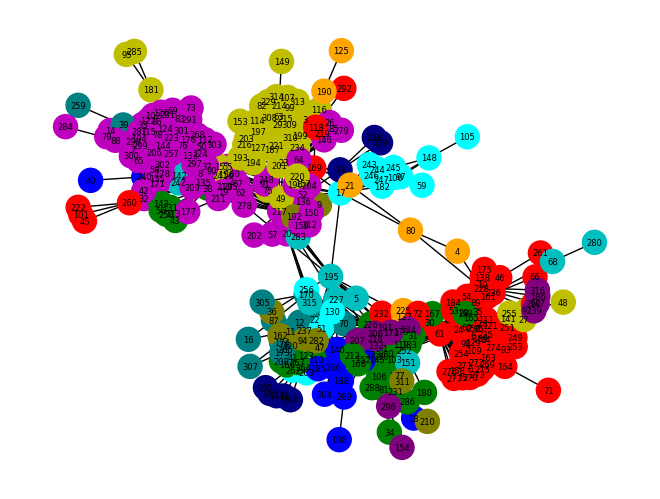

<Figure size 640x480 with 0 Axes>

In [37]:
# Compute communities using label propagation algorithm
communities_lp5 = list(nx_comm.label_propagation_communities(got_nw_prop5))

# Print the number of communities detected
print("Number of communities detected:", len(communities_lp5))

# Calculate and print the modularity
modularity_lp5 = nx_comm.modularity(got_nw_prop5, communities_lp5)
print("Modularity:", modularity_lp5)


# Create a color map for the communities
colors = ['r', 'g', 'b', 'c', 'm', 'y',  '#FFA500', '#800080', '#808000', '#00FFFF', '#008080', '#000080']
color_map = []

# Assign colors to nodes based on their community
for node in got_nw_prop5:
    # Find the community of the node
    for i, community in enumerate(communities_lp5):
        if node in community:
            color_map.append(colors[i % len(colors)])
            break

# Create a layout for the nodes
pos = nx.spring_layout(got_nw_prop5)

# Draw the graph
nx.draw(got_nw_prop5, pos, node_color=color_map, with_labels=True, font_size=6)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('lp_5.png', dpi=100)


Way more fragmented (33), many couples, triplets and single nodes. High modularity: 0.641.

##4.3 Clauset-Newman-Moore greedy modularity maximization

In [38]:
nodes_1.head(200)

,id,label
0,0,Addam-Marbrand
1,1,Aegon-I-Targaryen
2,2,Aemon-Targaryen-(Maester-Aemon)
3,3,Aerys-II-Targaryen
4,4,Aggo
...,...,...
182,182,Todder
183,183,Matthar
184,184,Othor
185,185,Paxter-Redwyne


In [39]:
nodes_5.head(350)

,id,label
0,0,Aegon-I-Targaryen
1,1,Aegon-Targaryen-(son-of-Rhaegar)
2,2,Aemon-Targaryen-(Maester-Aemon)
3,3,Aenys-Frey
4,4,Aeron-Greyjoy
...,...,...
312,312,William-Foxglove
313,313,Wex-Pyke
314,314,Willow-Witch-eye
315,315,Wylis-Manderly


Network Book 1

Number of communities detected: 7
Modularity: 0.4743959679901508


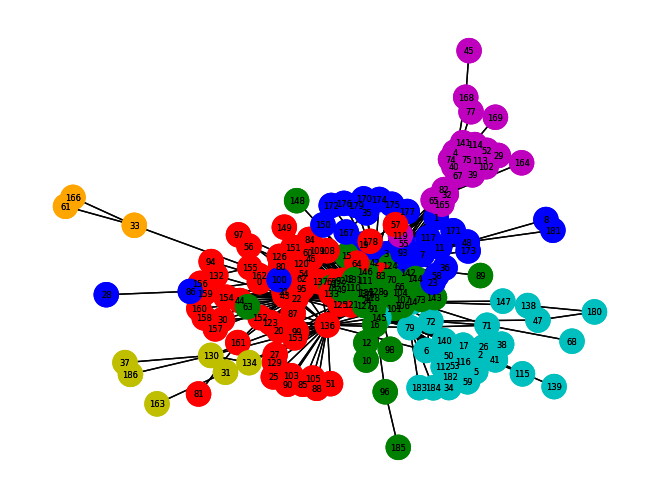

<Figure size 640x480 with 0 Axes>

In [40]:
# Compute communities using Clauset-Newman-Moore greedy modularity maximization
communities_cnm1 = list(nx_comm.greedy_modularity_communities(got_nw_prop))

# Print the number of communities detected
print("Number of communities detected:", len(communities_cnm1))

# Calculate and print the modularity
modularity_cnm1 = nx_comm.modularity(got_nw_prop, communities_cnm1)
print("Modularity:", modularity_cnm1)


# Create a color map for the communities
colors = ['r', 'g', 'b', 'c', 'm', 'y', '#FFA500', '#800080', '#808000', '#00FFFF', '#008080', '#000080']
color_map = []

# Assign colors to nodes based on their community
for node in got_nw_prop:
    # Find the community of the node
    for i, community in enumerate(communities_cnm1):
        if node in community:
            color_map.append(colors[i % len(colors)])
            break

# Create a layout for the nodes
pos = nx.spring_layout(got_nw_prop)

# Draw the graph
nx.draw(got_nw_prop, pos, node_color=color_map, with_labels=True, font_size=6)
# Draw the graph
nx.draw(got_nw_prop, pos, node_color=color_map, with_labels=True, font_size=6)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('cnm_1.png', dpi=100)


Clusters of Daenerys, Jon Snow still detected. The various families are better separated. Modularity of 0.474.

Network Book 5

Number of communities detected: 15
Modularity: 0.6297550207756232


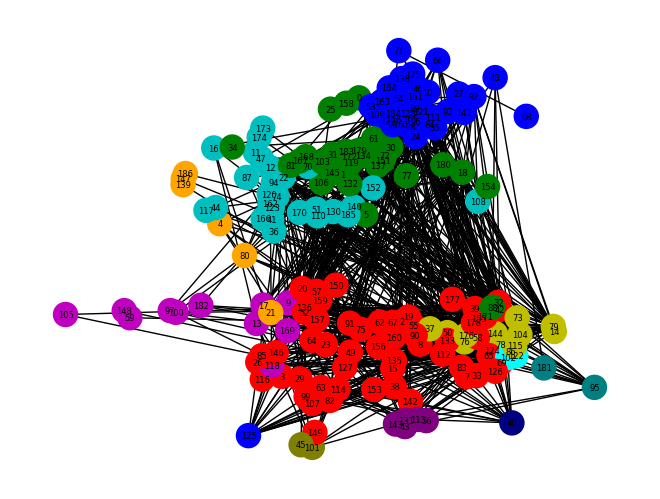

<Figure size 640x480 with 0 Axes>

In [41]:
# Compute communities using Clauset-Newman-Moore greedy modularity maximization
communities_cnm5 = list(nx_comm.greedy_modularity_communities(got_nw_prop5))

# Print the number of communities detected
print("Number of communities detected:", len(communities_cnm5))

# Calculate and print the modularity
modularity_cnm5 = nx_comm.modularity(got_nw_prop5, communities_cnm5)
print("Modularity:", modularity_cnm5)


# Create a color map for the communities
colors = ['r', 'g', 'b', 'c', 'm', 'y', '#FFA500', '#800080', '#808000', '#00FFFF', '#008080', '#000080']
color_map = []

# Assign colors to nodes based on their community
for node in got_nw_prop:
    # Find the community of the node
    for i, community in enumerate(communities_cnm5):
        if node in community:
            color_map.append(colors[i % len(colors)])
            break

# Create a layout for the nodes
pos = nx.spring_layout(got_nw_prop5)

# Draw the graph
nx.draw(got_nw_prop, pos, node_color=color_map, with_labels=True, font_size=6)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('cnm_5.png', dpi=100)


The communities detected from the algorithm in the 5th book are 15. The distance from the nodes well reflects how the various characters and families develop in distant lands, as the narration expand in time and space during the last chapter of the saga.

##4.4 Louvain

This algorithm was performed through Gephi.

Network Book 1:

- Number of communities detected: 7
- Modularity: 0.514

Network Book 5:

- Number of communities detected: 11
- Modularity: 0.704

##4.5 Comparison

Communities detection algorithms comparison for Book 1

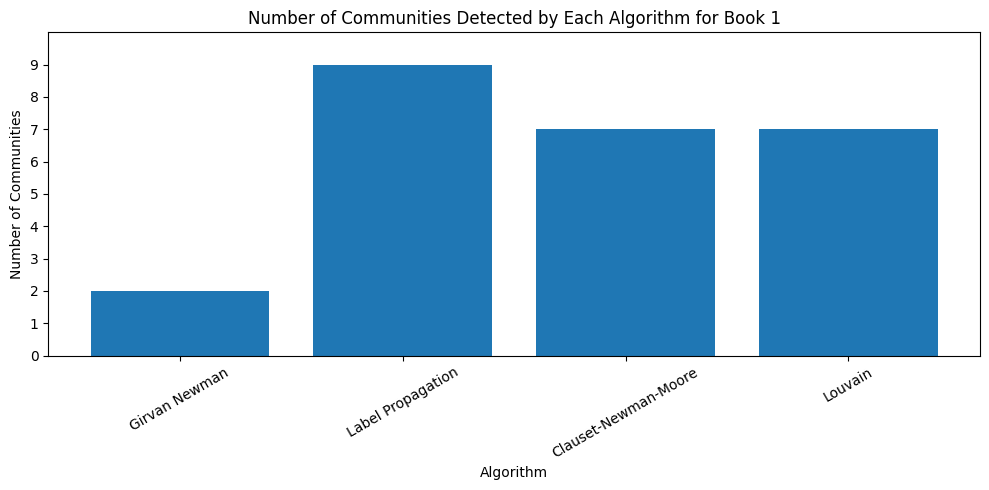

<Figure size 640x480 with 0 Axes>

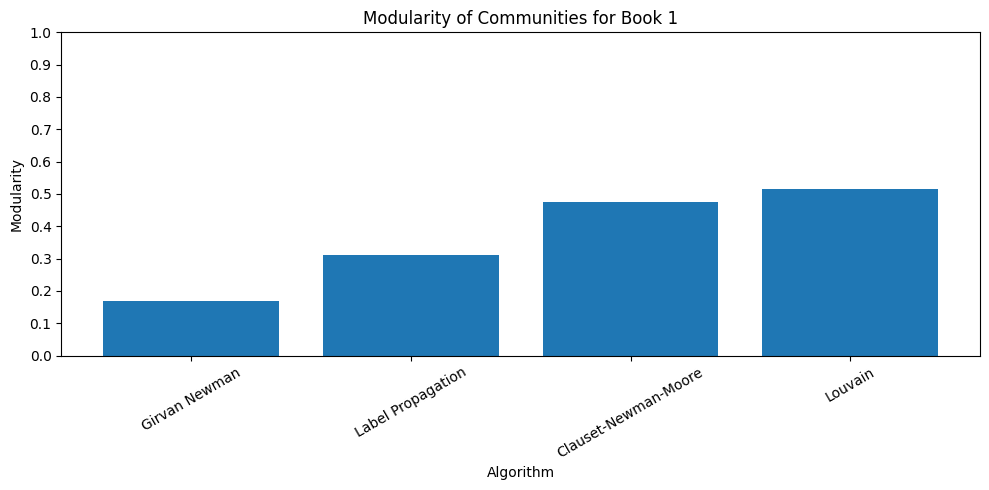

<Figure size 640x480 with 0 Axes>

In [47]:
# Compute communities and modularity for various algorithms
algorithms = ['Girvan Newman', 'Label Propagation', 'Clauset-Newman-Moore', 'Louvain']
num_communities = []
modularities = []

# Girvan Newman
num_communities.append(len(communities_gn1))
modularities.append(round(modularity_gn1, 3))

# Label Propagation
num_communities.append(len(communities_lp1))
modularities.append(round(modularity_lp1, 3))

# Clauset-Newman-Moore
num_communities.append(len(communities_cnm1))
modularities.append(round(modularity_cnm1, 3))

# Louvain
num_communities.append(7)
modularities.append(0.514)


# Plot number of communities
plt.figure(figsize=(10, 5))
plt.bar(algorithms, num_communities)
plt.xlabel('Algorithm')
plt.ylabel('Number of Communities')
plt.title('Number of Communities Detected by Each Algorithm for Book 1')
plt.ylim([0, 10])
plt.yticks(np.arange(0, max(num_communities)+1, 1))
plt.xticks(rotation=30, fontsize=10)  # Rotate x-ticks and decrease font size
plt.tight_layout()  # Adjust layout to prevent clipping of labels

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('num_comm_comparison_1.png', dpi=100)



# Plot modularities
plt.figure(figsize=(10, 5))
plt.bar(algorithms, modularities)
plt.xlabel('Algorithm')
plt.ylabel('Modularity')
plt.title('Modularity of Communities for Book 1')
plt.ylim([0, 1.0])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(rotation=30, fontsize=10)
plt.tight_layout()

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('modularity_comparison_1.png', dpi=100)

Communities detection algorithms comparison for Book 5

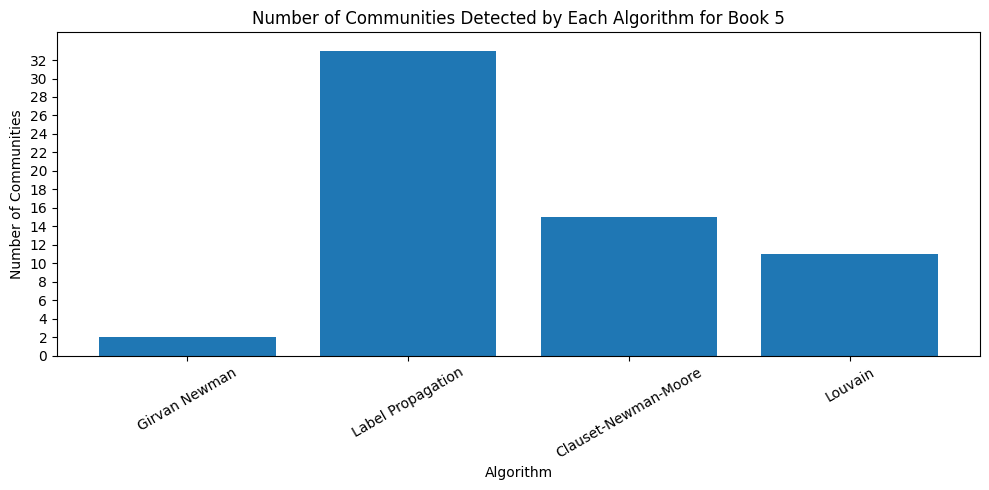

<Figure size 640x480 with 0 Axes>

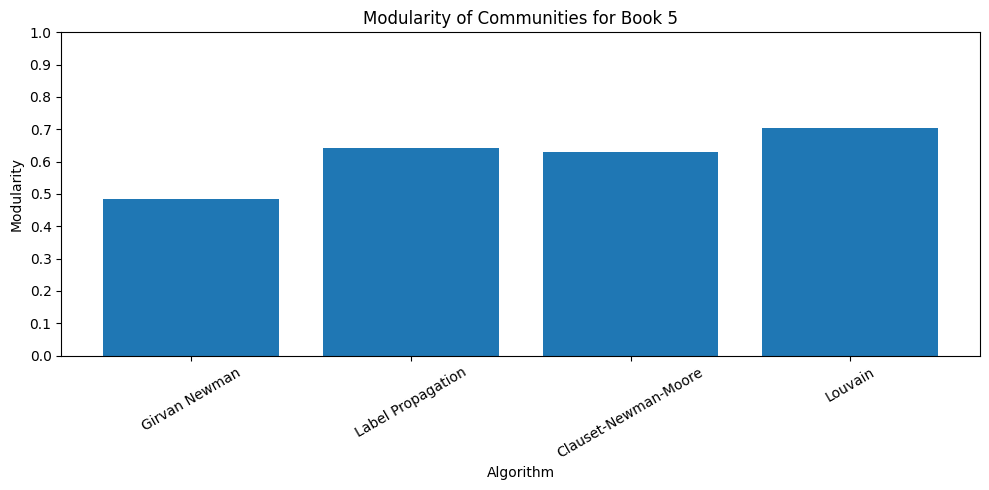

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [48]:
# Compute communities and modularity for various algorithms
algorithms = ['Girvan Newman', 'Label Propagation', 'Clauset-Newman-Moore', 'Louvain']
num_communities = []
modularities = []

# Girvan Newman
num_communities.append(len(communities_gn5))
modularities.append(round(modularity_gn5, 3))

# Label Propagation
num_communities.append(len(communities_lp5))
modularities.append(round(modularity_lp5, 3))

# Clauset-Newman-Moore
num_communities.append(len(communities_cnm5))
modularities.append(round(modularity_cnm5, 3))

# Louvain
num_communities.append(11)
modularities.append(0.704)


# Plot number of communities
plt.figure(figsize=(10, 5))
plt.bar(algorithms, num_communities)
plt.xlabel('Algorithm')
plt.ylabel('Number of Communities')
plt.title('Number of Communities Detected by Each Algorithm for Book 5')
plt.yticks(np.arange(0, max(num_communities)+1, 2))
plt.xticks(rotation=30, fontsize=10)  # Rotate x-ticks and decrease font size
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.ylim([0, 35])

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('num_comm_comparison_5.png', dpi=100)


# Plot modularities
plt.figure(figsize=(10, 5))
plt.bar(algorithms, modularities)
plt.xlabel('Algorithm')
plt.ylabel('Modularity')
plt.title('Modularity of Communities for Book 5')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(rotation=30, fontsize=10)
plt.tight_layout()
plt.ylim([0, 1.0])
plt.show()

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('modularity_comparison_5.png', dpi=100)

#5. Conclusion

The results suggest significant shifts in the network structure and character roles between the two books. The network's density, modularity, and average path length evolve, reflecting the narrative's progression from a relatively unified realm to a more fragmented and complex political landscape.

Moreover, the changing centrality measures of characters provide fascinating insights into their evolving roles and importance in the narrative. Characters who were peripheral in the first book emerge as significant players by the fifth, while some initially central characters fade in prominence. A clear example is represented by Daenerys, out of the top 15 highest degree nodes in the first book, ends up as the second highest connected charcters in the final book, as her importance grows exponentially in the narration. On the other side many characters drop drastically in degree, as the saga is well known for its ruthless elimination of main heroes from the story (Eddard Stark is the most evident example).
Community detection is also very informative of the newborn alliances and fights taht emerge as the story progress. The approach of Daeneys to the events of the life at court is a clear case.

To conclude, this study offers a novel perspective on "Game of Thrones" and it demonstrates the potential of network science to illuminate the underlying structures and dynamics of complex literary works.